<a href="https://colab.research.google.com/github/Kolo-Naukowe-Axion/QC1/blob/Hipoteza-Rafa%C5%82-2/model_odra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Quantum Classifier

In [ ]:
%pip install qiskit qiskit_machine_learning
%pip install ucimlrepo
%pip install torch
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset


import sys          # Standard library module for system-specific parameters and functions
import subprocess   # Standard library module for spawning new processes
from sklearn.preprocessing import MinMaxScaler # Importuje MinMaxScaler do skalowania danych
from sklearn.model_selection import train_test_split # Importuje train_test_split do podziału danych
from ucimlrepo import fetch_ucirepo     # Importuje fetch_ucirepo do pobierania zestawów danych z UCI ML Repository
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


In [ ]:
import sys
import subprocess
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo


def ensure_package(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])

# Ensure all requirements are met
ensure_package('numpy')
ensure_package('scikit-learn', 'sklearn')
ensure_package('ucimlrepo')
ensure_package('qiskit')

def prepare_data():
    """
    Fetches the banknote authentication dataset and returns scaled train/test splits.
    Features are scaled to [0, pi] specifically for Angle Encoding.
    """
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling to [0, pi] ensures data maps perfectly to Ry rotation angles
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


# Global availability of data
X_tr, X_te, y_tr, y_te = prepare_data()

In [ ]:
def ansatz(n_qubits, depth):
    """
    The code below constructs the ansatz. It is built using the Qiskit library
    and utilizes its built-in tools, such as ParameterVector, to easily iterate
    over rotation gate parameters.

    The implementation assumes the use of 4 qubits and an even number of layers
    (depth). Each layer consists of a sub-layer of independent gates and a
    sub-layer of entanglement.
    """

    # Create a vector of learnable parameters.
    # Total parameters = 8 * depth (16 per full loop iteration).
    theta = ParameterVector('θ', 8 * depth)
    qc = QuantumCircuit(n_qubits)

    # The loop iterates (depth // 2) times.
    # This structure requires 'depth' to be even to execute full blocks.
    for j in range(depth // 2):


        # -------- Layer 1 --------

        # --- Sub-layer: Independent RY rotations --
        # Apply RY rotation to every qubit using the first set of parameters for this block.
        for i in range(n_qubits):
            qc.ry(theta[j * n_qubits * 4 + i], i)

        # --- Sub-layer: Entanglement (CRX) ---
        # Controlled-RX gates creating a specific ring topology.
        qc.crx(theta[j * n_qubits * 4 + 4], 3, 0)
        qc.crx(theta[j * n_qubits * 4 + 5], 2, 3)
        qc.crx(theta[j * n_qubits * 4 + 6], 1, 2)
        qc.crx(theta[j * n_qubits * 4 + 7], 0, 1)


        # -------- Layer 2 --------

        # --- Sub-layer: Independent RX rotations ---
        # Apply RX rotation to every qubit using the second set of parameters (offset by 8).
        for i in range(n_qubits):
            qc.rx(theta[j * n_qubits * 4 + 8 + i], i)

        # --- Sub-layer: Entanglement (CRY) ---
        # Controlled-RY gates creating a different ring topology.
        qc.cry(theta[j * n_qubits * 4 + 12], 3, 2)
        qc.cry(theta[j * n_qubits * 4 + 13], 0, 3)
        qc.cry(theta[j * n_qubits * 4 + 14], 1, 0)
        qc.cry(theta[j * n_qubits * 4 + 15], 2, 1)

    return qc

In [ ]:
from qiskit.primitives import PrimitiveResult, PubResult
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.primitives.containers.data_bin import DataBin
from qiskit import transpile
import numpy as np
import time

class SimpleIQMJob:
    """A dummy job that simply holds the result."""
    def __init__(self, result):
        self._result = result

    def result(self):
        return self._result

# --- THE BRIDGE CLASS ---
class IQMBackendEstimator(BaseEstimatorV2):
    def __init__(self, backend, options=None):
        super().__init__()
        self._backend = backend
        self._options = options or {"shots": 100}

    def run(self, pubs, precision=None):
        if not isinstance(pubs, list): pubs = [pubs]
        job_results = []

        # 1. Prepare Circuit
        base_circuit = pubs[0][0]
        circuit_with_meas = base_circuit.copy()
        if circuit_with_meas.num_clbits == 0:
            circuit_with_meas.measure_all()

        # 2. Transpile
        transpiled_qc = transpile(circuit_with_meas, self._backend, optimization_level=3)

        for pub in pubs:
            _, observables, parameter_values = pub
            if parameter_values.ndim == 1:
                parameter_values = [parameter_values]

            pub_expectations = []

            # Pętla wykonująca się dla każdej próbki w batchu (np. 32 razy)
            for i, params in enumerate(parameter_values):
                bound_qc = transpiled_qc.assign_parameters(params)

                # 3. Execute on Hardware (TU MIERZYMY CZAS JOBA)
                try:
                    # Start zegara dla pojedynczego joba
                    job_start = time.time()

                    job = self._backend.run(bound_qc, shots=self._options["shots"])
                    result = job.result()

                    # Stop zegara
                    job_end = time.time()
                    job_duration = job_end - job_start

                    # Wypisujemy czas tego konkretnego joba
                    print(f"Job {i+1}: {job_duration:.4f} s")

                    counts = result.get_counts()

                    if isinstance(counts, list): counts = counts[0]

                    # 4. Calculate Expectation
                    shots = sum(counts.values())
                    count_0 = 0
                    for bitstring, count in counts.items():
                        if bitstring[-1] == '0':
                            count_0 += count

                    p0 = count_0 / shots
                    p1 = 1 - p0
                    pub_expectations.append(p0 - p1)

                except Exception as e:
                    print(f"Job failed: {e}")
                    pub_expectations.append(0.0)

            data = DataBin(evs=np.array(pub_expectations), shape=(len(pub_expectations),))
            job_results.append(PubResult(data=data))

        return SimpleIQMJob(PrimitiveResult(job_results))

In [ ]:
"""
    The code below constructs the class HybridModel. It is built using the Qiskit and Pytorch library and
    and utilizes its built-in tools, to create a model connecting classical and quantum computing.

"""

class HybridModel(nn.Module):
    def __init__(self, ansatz_circuit, num_qubits):
        super().__init__()
        self.feature_map = self.angle_encoding(num_qubits)

        # Connecting the quantum circuit. Connecting our feature map (data) and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        # Firstly, we inicialize parameters. Our quantum model cannot tell whether the number came from ansatz or feature.
        # That is why here we sort them into two lists. If the number came from feature_map, then it will be a feature and the other way around.
        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        '''
        Measure the Z-operator (spin) on the very first qubit (q_0) and ignore all the other qubits.
        Qiskit reads the string in a reversed order, that is why the Z gate is on the end.
        SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)]) converts string into a mathematical matrix that Qiskit can use for calculations
        Coefficient = 1 is a weight we multiply our result by. In QML it is mostly set to 1
        '''

        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        # Estimator takes ansatz, observables and parameters (data and weights), returns the Expectation value.
        # !!!! CHANGE WHEN USING ON QUANTUM COMPUTER
        # Needed when running quantum simulations, it should be changed when implementing on real quantum computer
        estimator = StatevectorEstimator()

        # Compute the gradients of the sampling probability by the Parameter Shift Rule.
        gradient = ParamShiftEstimatorGradient(estimator)


        '''
        The EstimatorQNN
        This class from Qiskit Machine Learning is used to instantiate the quantum neural network.
        It leverages the Qiskit Primitives (Estimator) to efficiently calculate expectation values
        of the quantum circuit. This allows the model to output continuous, differentiable values (gradients)
        required for backpropagation in hybrid quantum-classical training.
        '''

        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )

        '''
        TORCH CONNECTOR
        This line initializes the TorchConnector, which serves as a bridge between Qiskit and PyTorch. It wraps the Quantum Neural Network (QNN)
        to make it function as a standard, differentiable PyTorch module (nn.Module).
        This integration allows the quantum parameters to be optimized using standard PyTorch tools like
        the Adam optimizer and automatic differentiation.
        '''
        self.quantum_layer = TorchConnector(self.qnn)

        """
        Creates a Feature Map circuit using Angle Encoding. It maps classical input vectors
        to the quantum space by applying Ry(theta) rotations on each qubit,
        where the rotation angle theta corresponds to the input feature value.
        This effectively encodes the data into the amplitudes of the quantum state
        """

    def angle_encoding(self, num_qubits):
        qc_data = QuantumCircuit(num_qubits)
        input_params = ParameterVector('x', num_qubits)
        for i in range(num_qubits):
            qc_data.ry(input_params[i], i)
        return qc_data

    '''
    This function acts as the main execution path. When the model receives data,
    the forward function passes it into the quantum layer to be processed.
    The quantum layer calculates the result based on the current circuit parameters and returns the prediction.
    '''
    def forward(self, x):
        return self.quantum_layer(x)

In [ ]:
EPOCHS = 6
BATCH_SIZE = 32
LEARNING_RATE = 0.02

train_loss_history = []
test_loss_history = []
acc_history = []

print("Loading data...")

X_train, X_test, y_train_raw, y_test_raw = prepare_data()

y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Data ready. Number of training samples: {len(X_train)}")

Loading data...
Data ready. Number of training samples: 1097


In [ ]:
# --- Preparing the DataLoader ---

# Data conversion to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Creating a dataset with X_train_tensor and Y_train_tensor
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Creating a DataLoader, which now automatically handles shuffle in the training loop
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



In [ ]:
# Defining a loss function (note for Axion, it it the same as Michał calculated manually with diff**2)
loss_function = torch.nn.MSELoss()

# Inicializing the model
final_ansatz = ansatz(4, 2)
model = HybridModel(final_ansatz, 4)

# Initializing the ADAM optimizer
# Now that Our HybridModel is written in Pytorch, optimizer can access the paramiters directly
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Starting training... Epochs: {EPOCHS}")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    batches_count = 0

    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()           # Reset gradients
        output = model(X_batch)         # Forward
        loss = loss_function(output, y_batch) # Loss
        loss.backward()                 # Backward
        optimizer.step()                # Update weights

        epoch_loss += loss.item()
        batches_count += 1

    # Evaluation on tensors
    with torch.no_grad(): # To test our model we turn off the gradients

        test_outputs = model(X_test_tensor)
        test_loss = loss_function(test_outputs, y_test_tensor).item()

        # Calculating accuracy:
        # test.outputs > 0 returns True or False, by using float() we convert bools to 1.0 and 0.0
        # Then, multiply it by two, so for True = 2.0 False = 0.0
        # Substract 1 and the labels are either 1.0 or -1.0
        predicted = (test_outputs > 0).float() * 2 - 1
        correct = (predicted == y_test_tensor).sum().item()
        test_accuracy = correct / len(y_test_tensor)

    avg_loss = epoch_loss / batches_count
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    acc_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")

Starting training... Epochs: 6
Epoch 1/6 | Avg loss: 0.4602 | Test Acc: 0.8509
Epoch 2/6 | Avg loss: 0.4020 | Test Acc: 0.8618
Epoch 3/6 | Avg loss: 0.3890 | Test Acc: 0.8655
Epoch 4/6 | Avg loss: 0.3924 | Test Acc: 0.8764
Epoch 5/6 | Avg loss: 0.3914 | Test Acc: 0.8582
Epoch 6/6 | Avg loss: 0.3856 | Test Acc: 0.8545


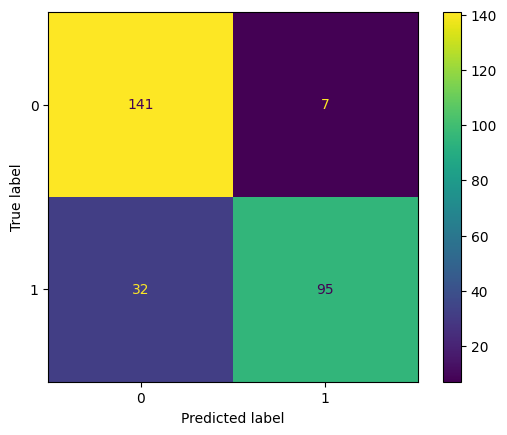

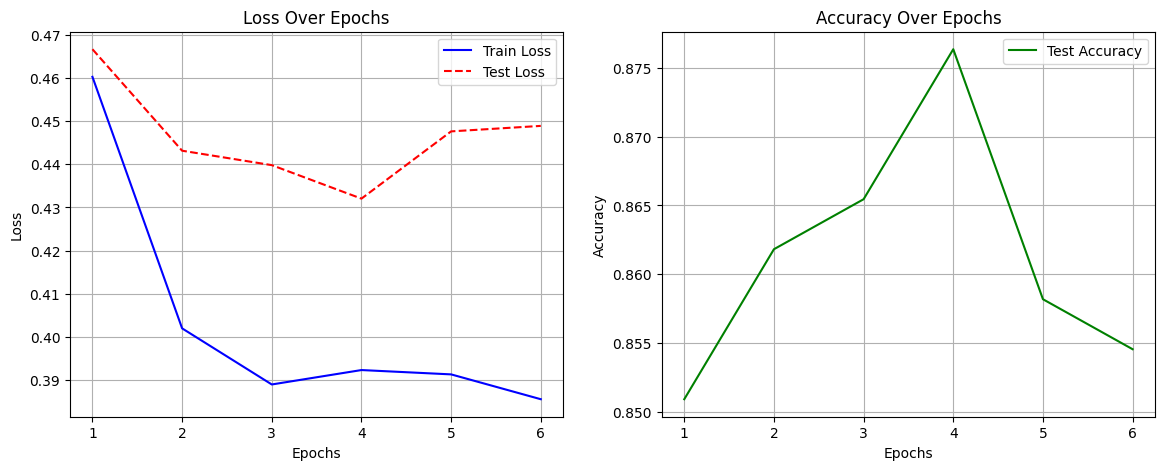

F1 SCORE:  0.8296943231441049  | ACCURACY SCORE:  0.8581818181818182


In [ ]:
with torch.no_grad():
    test_outputs_tensor = model(X_test_tensor)
    test_outputs = test_outputs_tensor.numpy()

predicted = np.where(test_outputs > 0, 1, -1).flatten()

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Test Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))

In [ ]:
from iqm.qiskit_iqm import IQMProvider
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

# 1. Connect to IQM

try:
    provider = IQMProvider("https://odra5.e-science.pl/", token=input("Enter IQM Token: "))
    iqm_backend = provider.get_backend()
    print(f"Connected to backend: {iqm_backend.name}")
except Exception as e:
    print(f"Connection error: {e}")

# 2. Instantiate the Bridge

hardware_estimator = IQMBackendEstimator(iqm_backend, options={"shots": 100})

# 3. Re-create the QNN for Hardware
print("Building Hardware QNN...")

# Reuse the same ansatz structure
hw_ansatz = ansatz(4, 2)
hw_feature_map = model.angle_encoding(4)

hw_qc = QuantumCircuit(4)
hw_qc.compose(hw_feature_map, qubits=range(4), inplace=True)
hw_qc.compose(hw_ansatz, inplace=True)

observable = SparsePauliOp.from_list([("I" * 3 + "Z", 1)])

# Create QNN with the HARDWARE ESTIMATOR
hw_qnn = EstimatorQNN(
    circuit=hw_qc,
    observables=observable,
    input_params=list(hw_feature_map.parameters),
    weight_params=list(hw_ansatz.parameters),
    estimator=hardware_estimator
)

# Create Torch Layer
iqm_model = TorchConnector(hw_qnn)

# 4. LOAD TRAINED WEIGHTS (CORRECTED LINE)
iqm_model.load_state_dict(model.quantum_layer.state_dict())
print("Trained weights transferred to IQM model!")

Enter IQM Token:  EX9CRLojLUqWZItGxR+eCVQrVTb+BiekNWYhpto7FC8Bm+yDo418MLEvc76lS4S4


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


✅ Connected to backend: IQMBackend
⚙️ Building Hardware QNN...
✅ Trained weights transferred to IQM model!


In [ ]:
# Select a sample from your test set
sample_idx = 0
sample_input = X_test_tensor[sample_idx]
actual_label = y_test_tensor[sample_idx].item()

print(f"🚀 Sending job to IQM Spark for sample {sample_idx}...")
print("   (This will take a moment to queue and execute)")

# Run forward pass (No gradients needed)
with torch.no_grad():
    # Pass input to the hardware model
    prediction = iqm_model(sample_input)

# Interpret result
predicted_label = 1 if prediction.item() > 0 else -1

print("-" * 30)
print(f"IQM Raw Output:    {prediction.item():.4f}")
print(f"Predicted Class:   {predicted_label}")
print(f"Actual Class:      {int(actual_label)}")
print("-" * 30)

🚀 Sending job to IQM Spark for sample 0...
   (This will take a moment to queue and execute)


Progress in queue:   0%|                                                                                             | 0/1 [02:41<?, ?it/s]


------------------------------
IQM Raw Output:    -0.2200
Predicted Class:   -1
Actual Class:      -1
------------------------------
